# Stratified Sampling
In this notebook, I will explore [stratified sampling](https://en.wikipedia.org/wiki/Stratified_sampling) both through simulation and analytical methods.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Suppose we have a population that can be partitioned into N subpopulations that are mutually exclusive and collectively exhaustive. That is, a member of the population must belong only to one subpopulation, and every member of the population must be assigned to a subpopulation based on some attribute or characteristic of the individual. Each subpopulation represents a fraction of the whole population and might have different variances for the statistic that is to be measured.

### Population with two subpopulations

Suppose we have a population and measure some random variable from it. Suppose the random variable is generated by the composition of two processes: a process that can be modeled through a normal distribution and another process modeled by an exponential distribution. Each subpopulation attribute is generated with only one of the methods, and the subpopulation proportions are known beforehand.

So, for the sake of the exploration, I know the population distribution and parameters and simulate sampling using different methods.

I will now use different sampling methods (random, stratified proportionate, and stratified disproportionate) to estimate population parameters such as mean and standard deviation.

In [2]:
group_a_proportion = 0.1
group_a_mean = 0
group_a_std = 1

group_b_proportion = 0.9
group_b_scale = 2
group_b_mean = group_b_scale
group_b_std = group_b_scale

# Overall population mean: weighted average of subpopulations' means
population_mean = group_a_proportion*group_a_mean + group_b_proportion*group_b_mean

# Overall population standard deviation formula
population_std = (group_a_proportion*group_a_std**2 + group_b_proportion*group_b_std**2+
                  group_a_proportion*group_b_proportion*(group_a_mean-group_b_mean)**2)**0.5

print(f"group_a_proportion: {group_a_proportion}")
print(f"group_a_mean: {group_a_mean}")
print(f"group_a_std: {group_a_std}")

print(f"group_b_proportion: {group_b_proportion}")
print(f"group_b_scale: {group_b_scale}")
print(f"group_b_mean: {group_b_mean}")
print(f"group_b_std: {group_b_std}")

print(f"population_mean: {population_mean}")
print(f"population_std: {population_std}")

group_a_proportion: 0.1
group_a_mean: 0
group_a_std: 1
group_b_proportion: 0.9
group_b_scale: 2
group_b_mean: 2
group_b_std: 2
population_mean: 1.8
population_std: 2.0149441679609885


These are the actual population parameters; I will try to estimate the population mean and standard deviation using different sampling methods. 

The population mean and standard deviation were [computed using the formulas](https://en.wikipedia.org/wiki/Pooled_variance#Population-based_statistics):

$$
\begin{aligned}\mu _{X\cup Y}&={\frac {N_{X}\mu _{X}+N_{Y}\mu _{Y}}{N_{X}+N_{Y}}}\\[3pt]\sigma _{X\cup Y}&={\sqrt {{\frac {N_{X}\sigma _{X}^{2}+N_{Y}\sigma _{Y}^{2}}{N_{X}+N_{Y}}}+{\frac {N_{X}N_{Y}}{(N_{X}+N_{Y})^{2}}}(\mu _{X}-\mu _{Y})^{2}}}\end{aligned}
$$

## Random sampling
In random sampling, one selects at random members from the population. Each individual of the population is equally likely to be chosen. We do not partition the population into subpopulations.

In [3]:
samples = 500

In [4]:
std_error = population_std/samples**0.5
std_error, (population_mean-1.96*std_error, population_mean+1.96*std_error) # 95% CI

(0.09011104260855048, (1.6233823564872412, 1.976617643512759))

Due to the CLT, with a sample size of 500, the sample mean through random sampling should be between the two numbers above 95% of the samples.

In [5]:
def random_sampling():
    """returns mean, std, sampled_proportion"""
    groups = np.random.random(size=samples)<=group_b_proportion
    group_b_size = groups.sum()
    group_a_size = samples - group_b_size
    sampled_proportion = group_b_size/samples
    
    # https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html
    group_a = np.random.normal(loc=group_a_mean, scale=group_a_std, size=group_a_size)

    # https://numpy.org/doc/stable/reference/random/generated/numpy.random.exponential.html
    group_b = np.random.exponential(scale=group_b_scale, size=group_b_size)

    both_groups = np.concat([group_a, group_b])

    return np.array([both_groups.mean(), both_groups.std(), sampled_proportion])

In [6]:
random_sampling_results = np.vstack([random_sampling() for _ in range(1000)])

In [7]:
# std_error = random_sampling_results[:,0].std()/samples**0.5
random_sampling_results[:,0].mean(), random_sampling_results[:,0].std() 

(np.float64(1.799852644635233), np.float64(0.08750751967646692))

In [8]:
random_sampling_results[:,1].mean(), random_sampling_results[:,1].std() 

(np.float64(2.0101105451265964), np.float64(0.12223997257755184))

In [9]:
random_sampling_results[:,2].mean(), random_sampling_results[:,2].std() 

(np.float64(0.89992), np.float64(0.01341646749334564))

[]

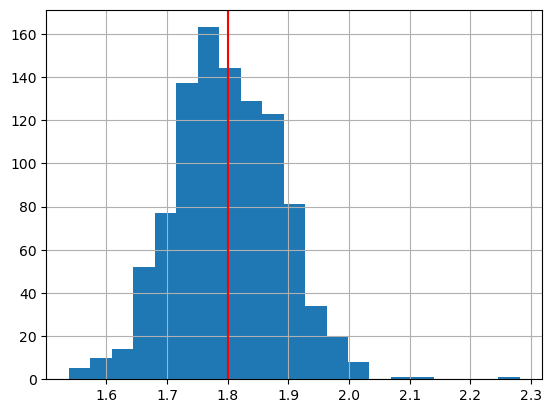

In [10]:
idx = 0
plt.hist(random_sampling_results[:,idx],bins=21, histtype='stepfilled')
plt.axvline(random_sampling_results[:,idx].mean(), color='red')
plt.grid()
plt.plot()

Through random sampling with a sample size of 500, I estimated the population mean of 1,801 and standard deviation of 2,008, which are incredibly close to the population actual values of 1,8 and 2,015.

## Proportionate Stratified sampling
Before sampling, let's assume we know the proportion of each subpopulation within the overall population. Then, we can sample from each subpopulation so that the samples reflect the overall subpopulation proportion. That is, we will draw samples from each subpopulation so that the proportion of the samples of the subpopulations is equal to the proportion of the subpopulations.

In [11]:
group_a_sz = int(samples * group_a_proportion)
group_b_sz = int(samples * group_b_proportion)

In [12]:
def stratified_sampling(group_a_sz, group_b_sz, return_raw=False):
    """Stratified sampling. returns mean, std, sampled_proportion"""
    # https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html
    group_a = np.random.normal(loc=group_a_mean, scale=group_a_std, size=group_a_sz)

    # https://numpy.org/doc/stable/reference/random/generated/numpy.random.exponential.html
    group_b = np.random.exponential(scale=group_b_scale, size=group_b_sz)

    both_groups = np.concat([group_a, group_b])

    if return_raw:
        return both_groups
    else:
        return np.array([both_groups.mean(), both_groups.std()])


def stratified_allocation_sem(group_a_proportion, group_a_disp_samples,
                                    group_b_proportion, group_b_disp_samples,
                                    std_ga, std_gb):
    """Standard error of the mean for disproportionate allocation"""
    return (
        (group_a_proportion*std_ga)**2 / group_a_disp_samples  + 
        (group_b_proportion*std_gb)**2 / group_b_disp_samples
    )**0.5

In [13]:
stratified_sampling_results = np.vstack([stratified_sampling(group_a_sz, group_b_sz) for _ in range(1000)])

In [14]:
stratified_sampling_results[:,0].mean(), stratified_sampling_results[:,0].std() 

(np.float64(1.800063532684721), np.float64(0.08698574972103433))

In [15]:
stratified_allocation_sem(
    group_a_proportion, group_a_sz,
    group_b_proportion, group_b_sz,
    group_a_std, group_b_std
)

0.08602325267042626

Notice that in proportionate stratified sampling the standard error of the mean (SEM) approximates to the analytical SEM in simple random sampling (SRS) when the sample size is large enough, but they are still different. The stratified SEM formula simplifies and approaches the SRS formula (ignoring the Finite Population Correction factor (FPC)):

$$ \sigma_{err}^2 = \frac{\sigma^2}{N} \approx \sum_{h=1}^L \frac{\sigma^2_h w_h^2}{n_h} $$

In [16]:
stratified_sampling_results[:,1].mean(), stratified_sampling_results[:,1].std() 

(np.float64(2.0079406096733297), np.float64(0.12846070902380485))

[]

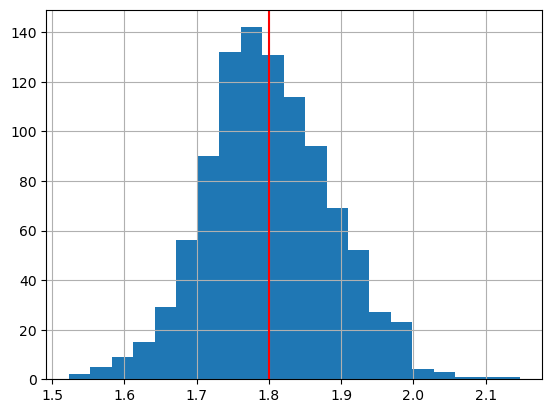

In [17]:
idx = 0
plt.hist(stratified_sampling_results[:,idx],bins=21, histtype='stepfilled')
plt.axvline(stratified_sampling_results[:,idx].mean(), color='red')
plt.grid()
plt.plot()

## Disproportionate Stratified sampling
In this scenario, we sample from each subpopulation separately, but the number of samples from each subpopulation will produce a proportion or fraction that is different from the true proportion within the population. 

For example, imagine subpopulations A and B partition the population into two groups, collectively exhaustive and mutually exclusive. Suppose the proper fraction of subpopulation A within the overall population is 1%; thus, the subpopulation B fraction is 99%. Let us sample each subpopulation separately and let Na and Nb be the number of samples for each group. In proportionate allocation, Na/(Na+Nb) would approximately match the overall population fraction (1%). Meanwhile, in disproportionate sampling, Na/(Na+Nb) will differ from the actual population sample. The difference in fractions or disproportion is usually caused by design because researchers and experimenters want to ensure they draw enough samples from each subpopulation to draw statistically significant conclusions instead of only for the overall population.

When stratified sampling with disproportionate allocation is used, the sampling weights used to draw conclusions from the population samples must be considered. If the sampling weights are ignored, the results obtained would be incorrect.

In [18]:
group_a_sampling_proportion = 0.5
group_b_sampling_proportion = 1 - group_a_sampling_proportion

group_a_disp_samples = int(group_a_sampling_proportion * samples)
group_b_disp_samples = int(group_b_sampling_proportion * samples)
group_a_disp_samples, group_b_disp_samples

(250, 250)

In [19]:
disproportionate_sampling_results = np.vstack([stratified_sampling(group_a_disp_samples, group_b_disp_samples) for _ in range(1000)])

In [20]:
disproportionate_sampling_results[:,0].mean(), disproportionate_sampling_results[:,0].std() 

(np.float64(0.9995671715678406), np.float64(0.06905839254948523))

In [21]:
disproportionate_sampling_results[:,1].mean(), disproportionate_sampling_results[:,1].std() 

(np.float64(1.8577625780484728), np.float64(0.11788506562215872))

[]

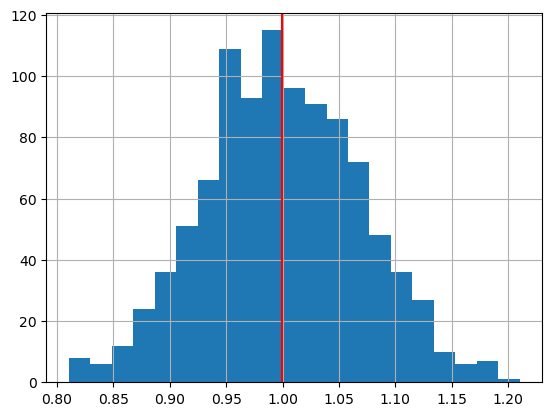

In [22]:
idx = 0
plt.hist(disproportionate_sampling_results[:,idx],bins=21, histtype='stepfilled')
plt.axvline(disproportionate_sampling_results[:,idx].mean(), color='red')
plt.grid()
plt.plot()

Notice how the mean appears to be one when in fact we know it is 1.8. This error occurs because I used disproportionate sampling and didn't account for sampling weights when computing statistics from the samples. That is, I sampled each subpopulation such that their sample sizes proportion is (group_a_sampling_proportion = 0.5), which is different from the true proportion of (group_a_proportion = 0.1).

To take into account sampling weights when the population was sampled with disproportionate stratified sampling:
1. We can perform a weighted bootstrap using the sampling weights from the samples or
2. compute statistics using analytical formulas and the sampling weights.

### Weighted bootstrapping
Bootstrapping supposes our sample is the entire population and draws samples with replacements. Weighted bootstrapping goes one step further to correct for the disproportionate allocation by assigning sampling weights to each sample. The process result simulates simple random sampling; thus, the SEM computed should converge to the SRS SEM, given we are considering sampling weights.

When you use weighted bootstrapping with the correct population weights, you are effectively simulating what would happen if you drew a simple random sample from the entire population, respecting the true population proportions.
In this case, the variance of the weighted mean (and thus the SEM) will match the SEM you would get from simple random sampling, i.e., population_std / sqrt(samples), if the allocation of samples to strata is proportionate (i.e., the sample fractions match the population fractions).

In [23]:
disproportionate_samples = stratified_sampling(
    group_a_disp_samples, 
    group_b_disp_samples, 
    return_raw=True
)
disproportionate_samples.shape

(500,)

In [24]:
sampling_weights = np.concat([
    np.ones(group_a_disp_samples)*group_a_proportion / group_a_disp_samples,
    np.ones(group_b_disp_samples)*group_b_proportion / group_b_disp_samples
])

sampling_weights.shape, sampling_weights.sum()

((500,), np.float64(0.9999999999999999))

In [25]:
a = np.random.choice(
    disproportionate_samples,
    size=[samples,1000],
    replace=True, # sampling with replacement
    p=sampling_weights
)
wb_mean_est = a.mean(axis=0).mean()
wb_std_est = a.std(axis=0).mean()
wb_sem_est = a.mean(axis=0).std()
print(f"Weighted bootstrapping estimate of the population mean: {wb_mean_est:.3f}")
print(f"Weighted bootstrapping estimate of the population std: {wb_std_est:.3f}" )
print(f"Weighted bootstrapping estimate of the standard error of the mean: {wb_sem_est:.3f}")

Weighted bootstrapping estimate of the population mean: 1.814
Weighted bootstrapping estimate of the population std: 2.114
Weighted bootstrapping estimate of the standard error of the mean: 0.095


Notice how we now obtained a reasonable estimate of the population mean, standard deviation, and standard error of the mean by weighted bootstrapping with the sampling weights (subpopulation proportions). The downside of weighted bootstrapping is that if our original sample is not well balanced, our results won't be either.

### Analytical computation using sampling weights
If we know to which subpopulation each sample belongs, we can partition the samples. If we also know the true proportion of each subpopulation in the overall population (or an estimate), we can compute statistics for each subpopulation and combine them with analytical formulas.

For example, the population mean equals the weighted mean of the subpopulation means:

In [26]:
mean_ga = disproportionate_samples[:group_a_disp_samples].mean()
mean_gb = disproportionate_samples[group_a_disp_samples:].mean()
std_ga = disproportionate_samples[:group_a_disp_samples].std()
std_gb = disproportionate_samples[group_a_disp_samples:].std()
overall_mean_est = mean_ga*group_a_proportion + mean_gb*group_b_proportion


mean_ga, mean_gb, std_ga, std_gb, overall_mean_est

(np.float64(-0.03616951801193335),
 np.float64(2.0207854615291967),
 np.float64(0.9789652268858128),
 np.float64(2.107616577834602),
 np.float64(1.815089963575084))

The result is very close to the actual population mean. Notice again how we corrected the disproportionate stratified sample through sampling weights (the subpopulation proportions). The estimated correct standard deviation of the population:

In [27]:
overall_std_est = (
    group_a_proportion*std_ga**2 + 
    group_b_proportion*std_gb**2 +
    group_a_proportion*group_b_proportion*(mean_ga-mean_gb)**2
)**0.5

overall_std_est

np.float64(2.115295702189032)

The result is again close to the population standard deviation. Lastly, the estimate of the standard error of the mean:

In [28]:
overall_std_est/samples**0.5

np.float64(0.09459889965215652)

`overall_std_est` is the estimated population standard deviation (SD) using the weighted sum of within-stratum variances and the between-stratum mean difference.
Dividing this by sqrt(samples) gives the SEM as if you had done simple random sampling from the whole population.

On the other hand, The stratified SEM formula: $$ \text{SEM}_\text{strat} = \sqrt{ \frac{(w_A \sigma_A)^2}{n_A} + \frac{(w_B \sigma_B)^2}{n_B} } $$ directly accounts for the actual allocation of samples to each stratum (i.e., $n_A$, $n_B$), and the population weights ($w_A$, $w_B$).

- Proportionate allocation: $n_h/n = w_h$ for all strata. In this case, both formulas are mathematically equivalent, so the SEMs match.
- Disproportionate allocation: $n_h/n \neq w_h$. Now, the stratified SEM formula is the correct one, and it will generally be larger than the SRS SEM (unless you use optimal allocation for variance minimization).

| Formula                         | Proportionate      | Disproportionate   | What it estimates                    |
|---------------------------------|--------------------|--------------------|--------------------------------------|
| `overall_std_est/samples**0.5`  | Correct            | Underestimates     | SRS SEM (ignores allocation)         |
| Stratified SEM formula          | Correct            | Correct            | True SEM for actual allocation       |
| Weighted bootstrap SEM          | Correct            | SRS SEM            | SRS SEM (not actual allocation)      |

The following formulas compute the SEM using the analytical formula for disproportionate stratified random sampling and ignoring the finite population correction factor (FPC). We need to keep in mind some caveats:
- If the allocation is not proportionate, the stratified SEM will not match the SRS SEM.
- If the strata have very different variances, the stratified SEM can be smaller (if allocation is optimal) or larger (if allocation is suboptimal) than the SRS SEM.
- The SRS formula ignores the stratification structure and assumes a single homogeneous population.

As a result, the SEM in proportionate stratified sampling can differ from the SEM in disproportionate stratified sampling. Thus:

- If you use proportionate stratified sampling, both formulas (SRS SEM and stratified sampling SEM) should give nearly the same result.
- If you use disproportionate stratified sampling, the stratified SEM formula will generally differ from the SRS formula.

The standard error of the mean (SEM) for disproportionate stratified sampling (ignoring the finite population correction) is:

$$
s_{\bar{x}}^2 = \sum_{h=1}^L w_h^2 \frac{s_h^2}{n_h}
$$

Where:
- $L$ = number of strata (subpopulations)
- $w_h$ = population weight of stratum $h$ (i.e., $w_h = N_h / N$, where $N_h$ is the population size of stratum $h$ and $N$ is the total population size)
- $s_h^2$ = sample variance of stratum $h$
- $n_h$ = number of observations sampled from stratum $h$

The standard error is then $s_{\bar{x}} = \sqrt{s_{\bar{x}}^2}$.

This formula accounts for different sample sizes and population proportions in each stratum.

The following SEM is an estimate since it uses the samples SD.

In [29]:
stratified_allocation_sem(
    group_a_proportion,
    group_a_disp_samples,
    group_b_proportion,
    group_b_disp_samples,
    std_ga,
    std_gb
)

np.float64(0.12012730442121375)

The following SEM is the theoretical SEM if we knew the subpopulation SDs:

In [30]:
stratified_allocation_sem(
    group_a_proportion,
    group_a_disp_samples,
    group_b_proportion,
    group_b_disp_samples,
    group_a_std,
    group_b_std
)

0.1140175425099138

Why can the analytical stratified SEM formula results differ from the SRS SEM?

The analytical stratified SEM formula accounts for the actual allocation of samples to each stratum. If your sampling is disproportionate (i.e., the sample fractions do not match the population fractions), the SEM from the stratified formula will generally be different from the SRS SEM.
Weighted bootstrapping, however, "corrects" for this by reweighting the samples to reflect the population, so the SEM it produces will match the SRS SEM, even if the original sample was disproportionate.

We can plot the expected SEM in stratified disproportionate allocation as a function of the sample sizes of each stratum. Assuming the total sample size constant equal to 500, and supposing we know the subpopulation SDs and proportions:

In [31]:

n_samples = np.arange(1,samples)
expected_sems = np.empty(n_samples.shape)

for n in n_samples:
    __group_a_disp_samples = n
    __group_b_disp_samples = 500 - n
    __sem = stratified_allocation_sem(
        group_a_proportion,
        __group_a_disp_samples,
        group_b_proportion,
        __group_b_disp_samples,
        std_ga,
        std_gb
    )
    expected_sems[n-1] = __sem

optimal_sample_size = np.argmin(expected_sems) + 1
optimal_expected_sem = expected_sems[optimal_sample_size-1]
print(f"Optimal sample size: {optimal_sample_size}")
print(f"Optimal expected SEM: {optimal_expected_sem:.3f}")

Optimal sample size: 25
Optimal expected SEM: 0.089


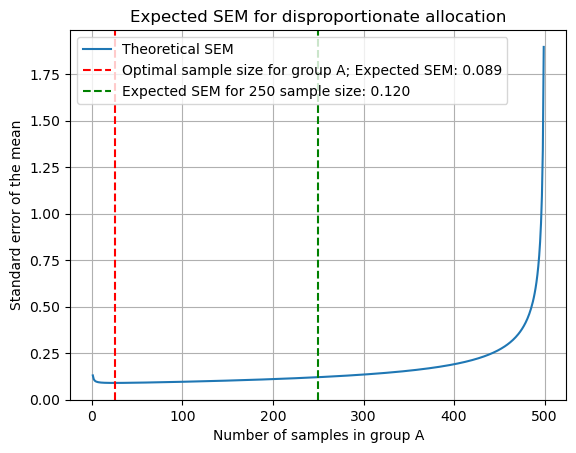

In [32]:
plt.plot(n_samples, expected_sems, label="Theoretical SEM")
plt.axvline(
    optimal_sample_size,
    color='red',
    linestyle='--',
    label=f"Optimal sample size for group A; Expected SEM: {optimal_expected_sem:.3f}"
)
plt.axvline(
    group_a_disp_samples,
    color='green',
    linestyle='--',
    label=f"Expected SEM for {group_a_disp_samples} sample size: {expected_sems[group_a_disp_samples-1]:.3f}"
)
plt.xlabel("Number of samples in group A")
plt.ylabel("Standard error of the mean")
plt.title("Expected SEM for disproportionate allocation")
plt.legend()
plt.grid()
plt.show()

The curve above will differ based on the parameters of the subpopulations such as averages and SD. There is a theoretical value of the sample sizes for each subpopulation that will yield the minimum expected SEM, such sample size is called optimal as it minimized the SEM.

There is a fundamental trade-off in stratified sampling design.

- **Optimal allocation** (Neyman allocation) minimizes the overall SEM of the population mean by allocating more samples to strata with higher variance and/or larger size. In this case, this leads to only 27 samples for population A, which is a small stratum with low variance.
- **Statistical significance within strata**: If the goal is to make reliable inferences about each subpopulation (not just the overall mean), one needs a sufficiently large sample in each stratum. Optimal allocation for the overall mean can leave small strata under-sampled, making it hard to estimate their means or variances with precision.
- **Practical survey design**: In real-world studies, researchers often set a minimum sample size per stratum to ensure statistical power for within-stratum analysis, even if this increases the overall SEM slightly.
- Optimal allocation is best if the only goal is to estimate the overall mean as precisely as possible.
If one cares about statistical significance within each subpopulation, one should ensure a minimum sample size per stratum, even if this is not "optimal" for the overall SEM.

This is a classic example of the trade-off between efficiency (minimizing overall error) and coverage (ensuring enough data for subgroup analysis) in survey and experimental design.

| Allocation Type         | Minimizes Overall SEM? | Good for Subpopulation Inference? | Typical Use Case                        |
|------------------------|-----------------------|-----------------------------------|-----------------------------------------|
| Proportionate          | No                    | Sometimes                         | General description of population       |
| Optimal (Neyman)       | Yes                   | Not always                        | Focus on overall mean estimation        |
| Equal/Min-per-stratum  | No                    | Yes                               | Subpopulation-specific conclusions      |

## Technicalities to understand this notebook

### Analytical mean and standard error

[The mean and variance of stratified random sampling are given by:](https://en.wikipedia.org/wiki/Stratified_sampling#Mean_and_standard_error)

$$
{\displaystyle {\bar {x}}={\frac {1}{N}}\sum _{h=1}^{L}N_{h}{\bar{x}}_{h}}
$$

$$
{\displaystyle s_{\bar {x}}^{2}=\sum _{h=1}^{L}\left({\frac {N_{h}}{N}}\right)^{2}\left({\frac {N_{h}-n_{h}}{N_{h}-1}}\right){\frac {s_{h}^{2}}{n_{h}}}}
$$

The average of the samples is computed through a weighted average.

Where
- $L$ = number of strata
- $N$ = the sum of all stratum sizes (population size for finite populations)
- $N_h$ = size of stratum h (subpopulation sizes)
- $\bar{x}_h$ = sample mean of stratum h
- $n_h$ = number of observations in stratum h (sample size of stratum h)
- $s_h$ = sample standard deviation of stratum h

Note that the term $(N_h-n_h)/(N_h-1)$ is a finite population correction (FPC). Forgoing the finite population correction can also give decent results when $n_h/N_h$ is relatively small, I.E. less than 0.05. Ignoring the finite population correction gives:

$$
s_{\bar {x}}^{2}=\sum _{h=1}^{L}\left({\frac {N_{h}}{N}}\right)^{2}{\frac {s_{h}^{2}}{n_{h}}}
$$

Where the $w_h = N_h/N$ is the population weight of stratum $h$.

### Standard Error of the Mean (SEM) vs Standard deviation (SD)

The **standard error** of the sample mean estimates how far the sample mean is likely to be from the sampling distribution mean. That is, if one were to repeat the same sampling procedure many times, how far apart we expect the sample mean to be from the sampling distribution average. In contrast, the **standard deviation** of the sample is the degree to which individuals within the sample differ from the sample mean. If the population standard deviation is finite, the standard error of the mean will tend to zero with increasing sample size because the estimate of the population mean will improve, while the standard deviation of the sample size will tend to approximate the population standard deviation as the sample size increases.

It is essential to differentiate between:
- The population standard deviation
- The sample standard deviation
- The standard error or standard deviation of the sample means. That is, the standard deviation of the sampling distribution.
- The estimator of the population's standard deviation, which is usually the sample standard deviation.

As the sample size tends to infinity, the central limit theorem (CLT) guarantees that the sampling distribution of the mean is asymptotically normal.

### How does the proportionate stratified sampling approximate SRS SEM?

Suppose we have two strata, A and B, with population weights $w_A$ and $w_B$, population standard deviations $\sigma_A$ and $\sigma_B$, and sample sizes $n_A$ and $n_B$. The total sample size is $n = n_A + n_B$.

The stratified SEM formula is:
$$
\text{SEM}_\text{strat} = \sqrt{ \frac{(w_A \sigma_A)^2}{n_A} + \frac{(w_B \sigma_B)^2}{n_B} }
$$

**Step 1: Proportionate allocation**

Under proportionate allocation:
$$
\frac{n_A}{n} = w_A \implies n_A = n w_A
$$
$$
\frac{n_B}{n} = w_B \implies n_B = n w_B
$$

**Step 2: Substitute $n_A$ and $n_B$ into the SEM formula**

$$
\text{SEM}_\text{strat} = \sqrt{ \frac{(w_A \sigma_A)^2}{n w_A} + \frac{(w_B \sigma_B)^2}{n w_B} }
$$
$$
= \sqrt{ \frac{w_A \sigma_A^2}{n} + \frac{w_B \sigma_B^2}{n} }
$$
$$
= \sqrt{ \frac{w_A \sigma_A^2 + w_B \sigma_B^2}{n} }
$$

**Step 3: Recognize the weighted population variance**

The weighted population variance for the whole population is:
$$
\sigma^2 = w_A \sigma_A^2 + w_B \sigma_B^2 + w_A w_B (\mu_A - \mu_B)^2
$$

If the means are equal or the between-stratum variance is negligible, the variance simplifies to:
$$
\sigma^2 \approx w_A \sigma_A^2 + w_B \sigma_B^2
$$

**Step 4: Final SRS SEM formula**

So, the SEM under SRS is:
$$
\text{SEM}_\text{SRS} = \frac{\sigma}{\sqrt{n}}
$$

And under proportionate allocation, the stratified SEM formula becomes:
$$
\text{SEM}_\text{strat} = \sqrt{ \frac{\sigma^2}{n} } = \frac{\sigma}{\sqrt{n}}
$$

**Conclusion:**  
The proportionate stratified sampling SEM formula only exactly simplifies to the SRS SEM formula if the means of the strata are equal (or the between-stratum variance is negligible).

In general, the SRS SEM formula is: $$ \text{SEM}_\text{SRS} = \frac{\sigma}{\sqrt{n}} $$ where $\sigma^2$ is the total population variance, which includes both the within-stratum variances and the between-stratum variance: $$ \sigma^2 = \sum_h w_h \sigma_h^2 + \sum{h < k} w_h w_k (\mu_h - \mu_k)^2 $$

The proportionate stratified SEM formula (ignoring FPC) is: $$ \text{SEM}\text{strat} = \sqrt{ \sum_h \frac{w_h^2 \sigma_h^2}{n_h} } $$ With $n_h = n w_h$ (proportionate allocation), this becomes: $$ \text{SEM}\text{strat} = \sqrt{ \frac{ \sum_h w_h \sigma_h^2 }{n} } $$


The SRS SEM formula uses the total population variance (including between-stratum variance).
The proportionate stratified SEM formula only uses the sum of the within-stratum variances.
Therefore:

If the stratum means are equal (no between-stratum variance), the two formulas are equal.
If the stratum means differ, the SRS SEM will be larger because it includes the between-stratum variance, while the stratified SEM (with proportionate allocation) does not.
Conclusion:
The stratified SEM formula under proportionate allocation is an approximation to the SRS SEM formula, and they are only exactly equal if the between-stratum variance is zero. In most practical cases, they are close but not identical.

